# Workshop on Kendra

In this workshop, we will build a search engine using AmazonKendra. 

Here is the **agenda for the workshop**:

- Types of queries and data formats supported
- Preparing the data for Indexing:
    - Creating the index
    - Adding data sources to Index
    - Adding metadata
- Creating FAQ
- Adding Synonyms
- Kendra Query using API
- Tuning search relevance at Index
- Intro on submitting feedback on incremental learning
- How use CDE (Custom Document Enrichment) to add metadata during ingestion
- Updating query suggestion config
- How to do access control 

## Types of queries and data formats supported

Kendra is an intelligent search service that enables your users to search unstructured and structured data using natural language processing and advanced search algorithms.

users can ask the following types of questions, or queries:

**Factoid questions** — Simple who, what, when, or where questions. The answer is retrieved from a FAQ or from your indexed documents.

**Descriptive questions** — Questions whose answer could be a sentence, passage, or an entire document. For example, How do I apply for employment pass?

**Keyword searches** — Questions where the intent and scope are not clear. For example, "keynote address". As 'address' can often have several meanings, Amazon Kendra can infer the user's intent behind the search query to return relevant information aligned with the user's intended meaning. Amazon Kendra uses deep learning models to handle this kind of query.

An index can include both **structured and unstructured text**:

- Structured text: Frequently asked questions and answers
- Unstructured text: HTML, Microsoft PowerPoint, Microsoft Word, Plain text, PDFs

For audio and video files, we have a solution called media search. Please refer to below blog for more details.
https://aws.amazon.com/blogs/machine-learning/make-your-audio-and-video-files-searchable-using-amazon-transcribe-and-amazon-kendra/

Amazon Kendra returns **three types of query response**.

- **Answer** (if Kendra detects an answer in the documents)
- **Question_answer** (A question and answer response is returned when Kendra matches a question with one of the FAQs in your index)
- **Document** (Kendra returns ranked documents for those that match the search term)


### Creating the INDEX

The first step is to create the INDEX. We will create the index using console but you can do it using API too. 

1. Go to Kendra console and click on "Create an Index"

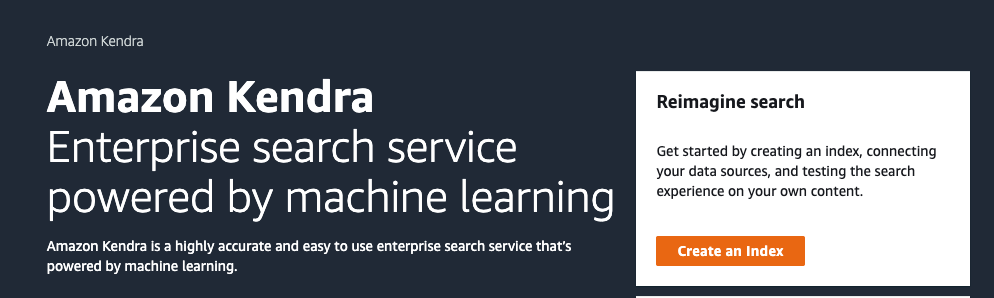

2. Specify the index details as shown here. Create a new IAM role and give it a name

3. In the next window, choose default settings for "Configure user access control" 

4. Choose default settings for "Specify provisioning" i.e. developer edition. The developer edition provides the following:

- Up to 5 indexes with up to 5 data sources each.
- 10,000 documents or 3 GB of extracted text.
- Approximately 4,000 queries per day

Index creation will around 15~20 min.

## Ingesting Data

Amazon Kendra offers a connector for Amazon S3 that allows document ingestion to Kendra using S3 as the data source.

Kendra supports a lot of data sources and you can find the list in our documentation
https://docs.aws.amazon.com/kendra/latest/dg/hiw-data-source.html

For this workshop, you are going to index a set of AWS whitepapers in PDF format, these documents are stored on different directories within the archive depending on their category, for example Best_Practices. 

If you need crawl webpages, one of the ways is to use the **web crawler that kendra offers** which will crawl and index the documents. When you use the web crawler to crawl webpages and index them as your documents, you specify the websites you want to crawl and index. You provide either the seed or starting point URLs or the sitemap URLs. 
https://docs.aws.amazon.com/kendra/latest/dg/data-source-web-crawler.html

In [5]:
import boto3
from PIL import Image
import json
import html
import sagemaker

s3=boto3.resource('s3')
region = boto3.session.Session().region_name
role = sagemaker.get_execution_role()

s3Bucket = sagemaker.Session().default_bucket()

Run the below cell to copy the data from "ml-materials" bucket where the workshop materals are stored.

In [ ]:
!aws s3 cp s3://ml-materials/whitepapers/ s3://{s3Bucket}/whitepapers --recursive  

2. Now that you have the documents into an S3 bucket, you can go to the Amazon Kendra console, go to your index and click on Datasources.

3. CLick on "add data sources" and click on "Add Connector" for Amazon S3.

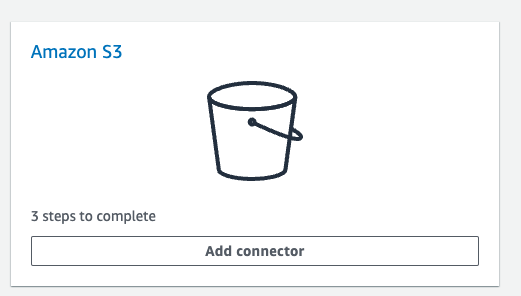

4. Specify data source name e.g. "workshop_s3_connector"

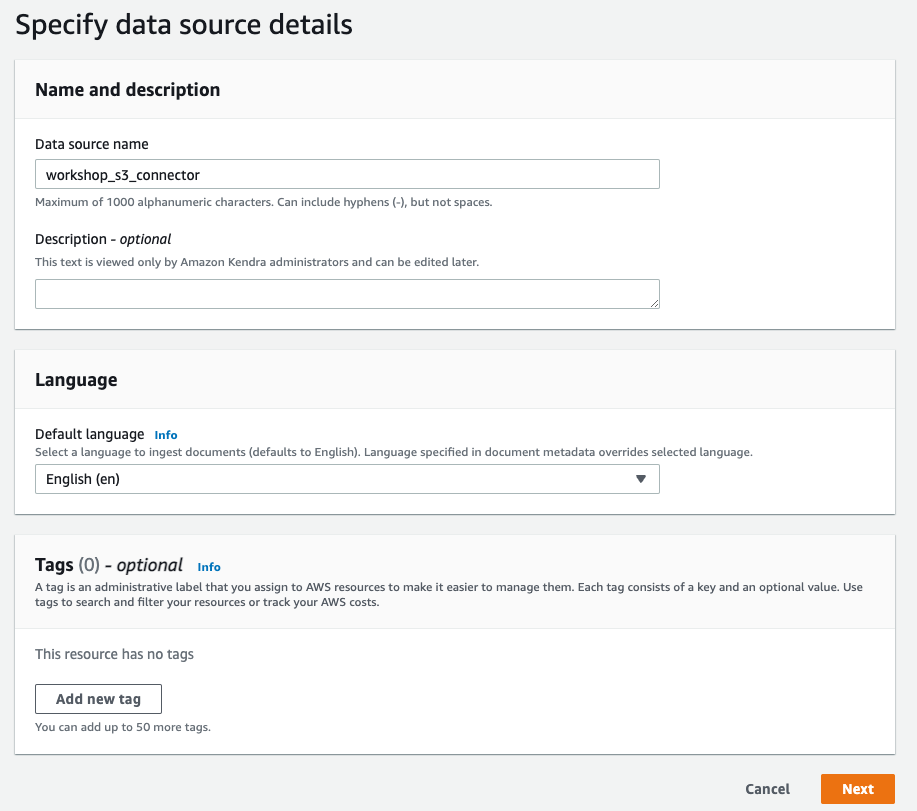

5. Under sync settings, browse S3 and select the bucket name.

6. Under additional configuration, you can include the prefix, which is same as your S3 folder name e.g. "whitepapers" 

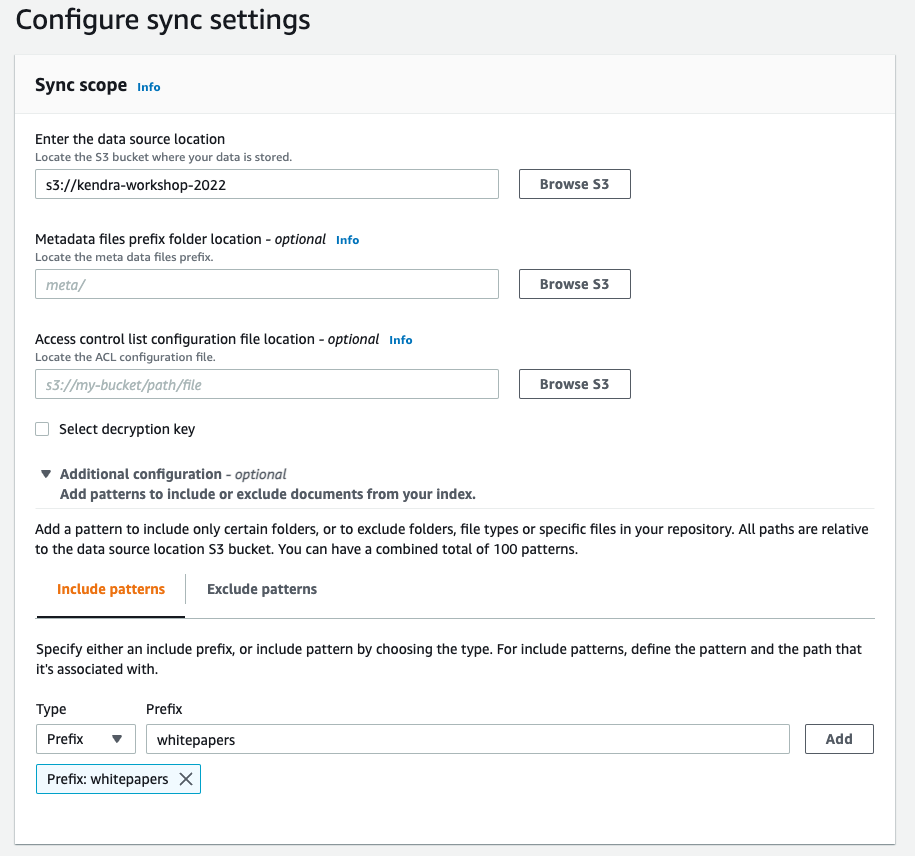

7. Create a New IAM Role. Give a name to the IAM role.

8. On the Set sync run schedule click on Next.

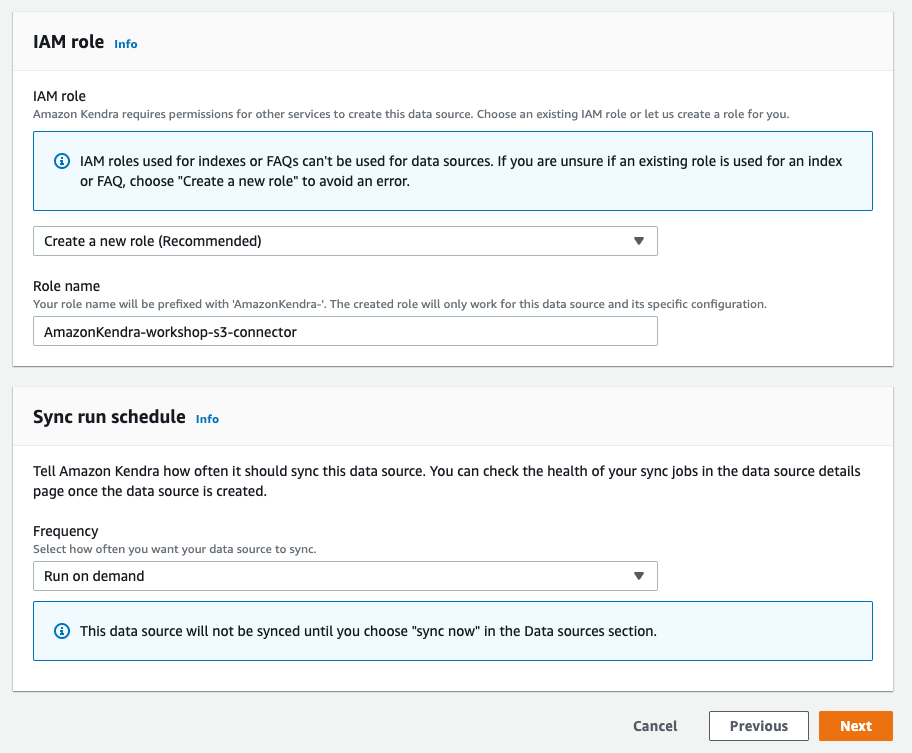

9. Click on Add data source. It will take 1~2 min to create the data source.

10. After the creation process is complete, click on **Sync Now.**

Syncing will take 5~10 min.

Once syncing is done, you should see 60 documents added as shown below. You can now try out some search query using "Search indexed content"

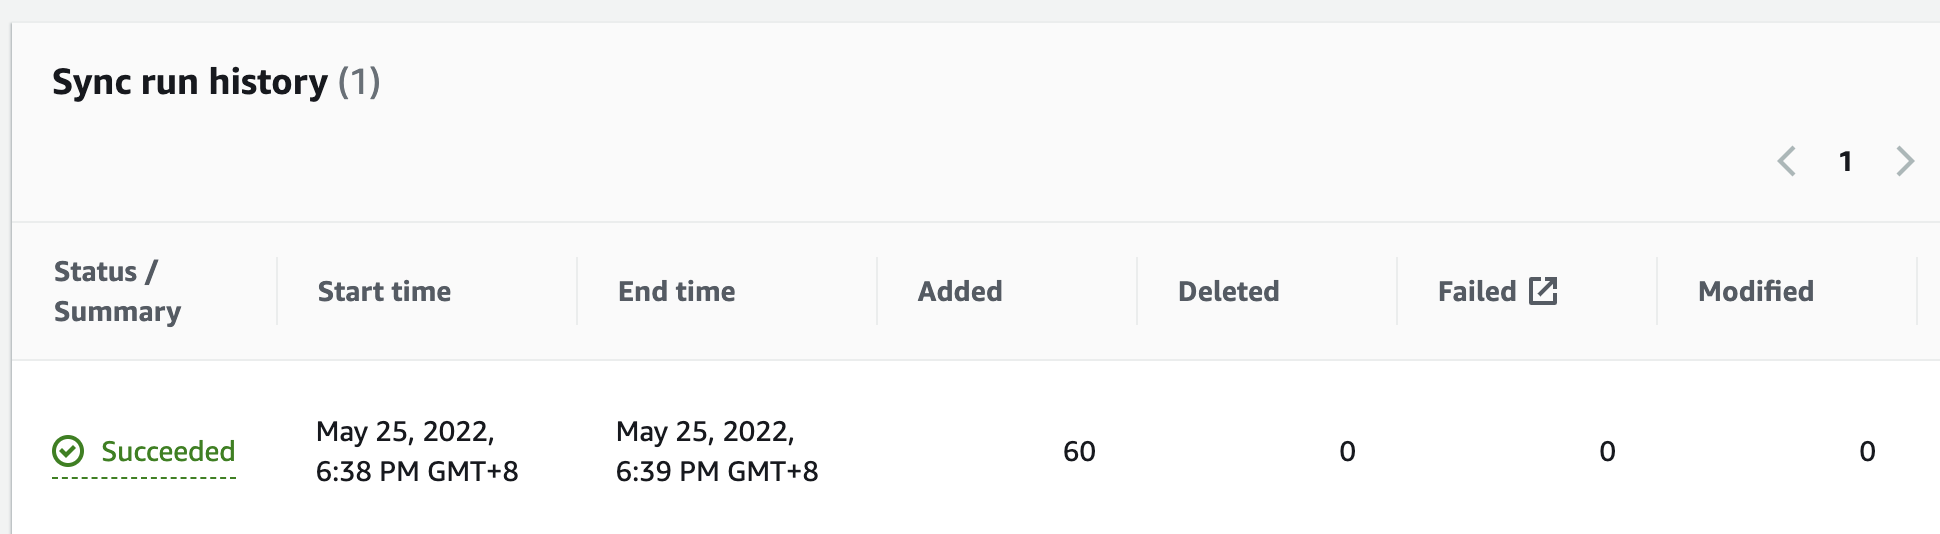

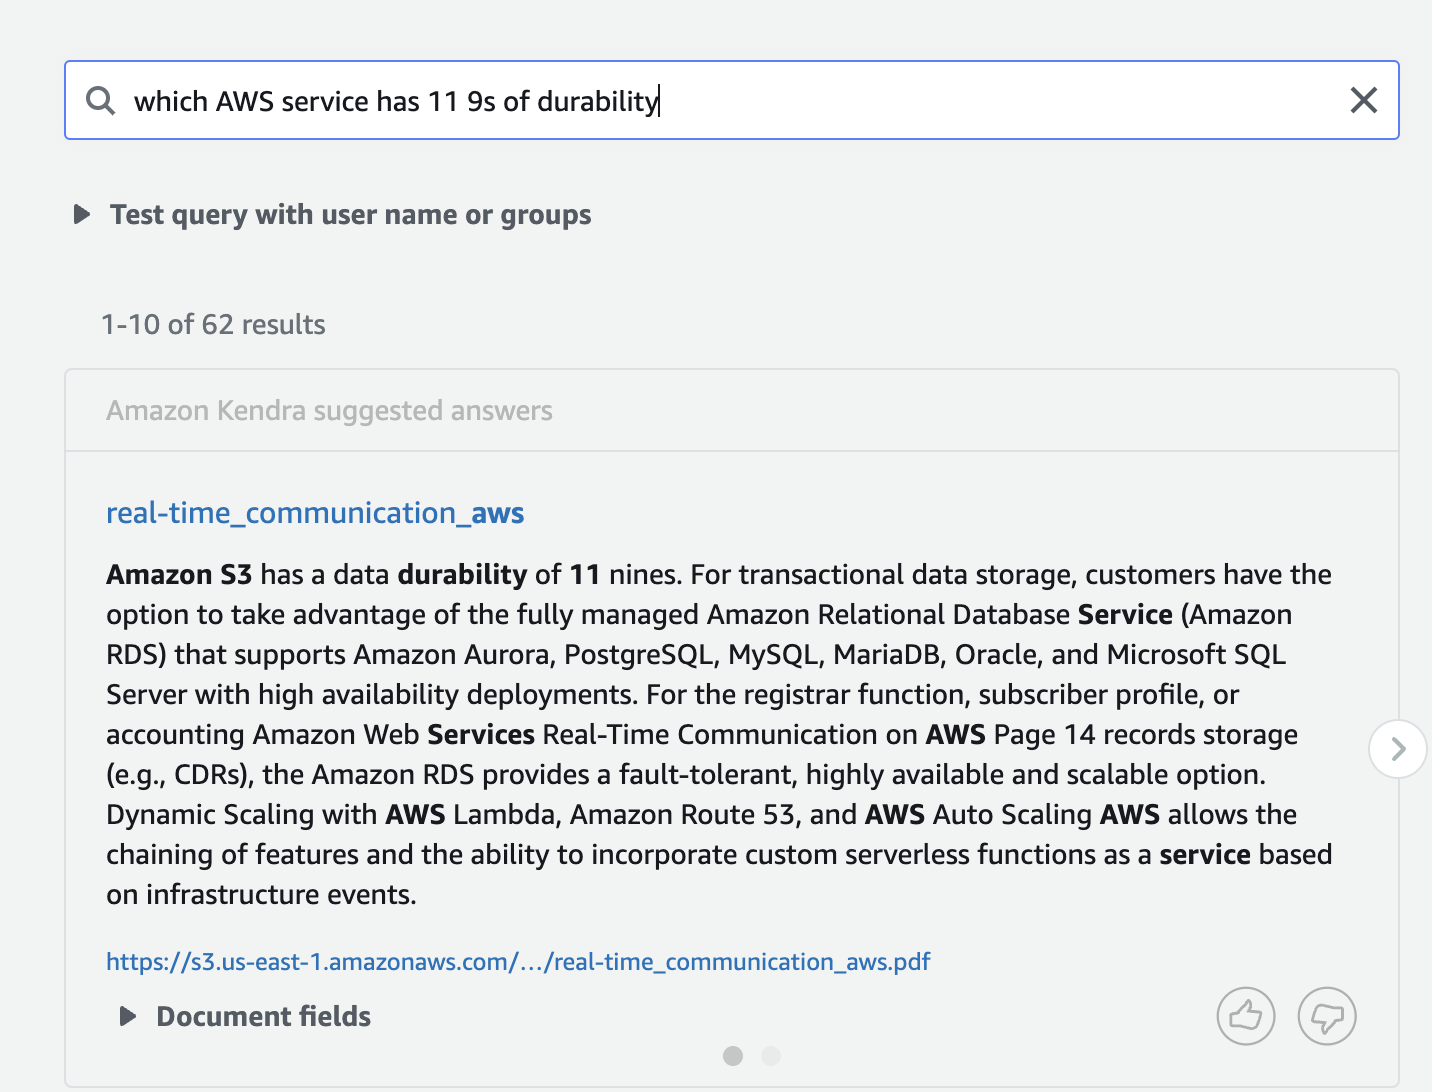

Although the search is working, you can't do any filtering as we have not added any metadata yet.

## Adding metadata and creating custom attributes

Now, we will use some metadata so that we can add some custom attributes to the search such as "Category" to enrich our search query. This will help to narrow down the search to specific categories and also allow you to boost the search if needed.

**We should keep the metadata files in the same folder as the documents.**

There should be one metadata file per input file. 
**How Kendra detects the metadata file is based on the naming convention. If file name is "AmazonS3BestPractices.pdf" then metadata file should be "AmazonS3BestPractices.pdf.metadata.json"** This is important! 

Amazon Kendra has 15 **Reserved Attributes** that you can use or you can create **Custom Attributes**. 

Example of reserved attributes:

_authors (String list) – A list of one or more authors responsible for the content of the document.<br>
_category (String) – A category that places a document in a specific group.<br>
_source_uri (String) – The URI where the document is available. For example, the URI of the document on a company website.

Below is one example of metadata extracted from a PDF doc - "AmazonS3BestPractices.pdf"

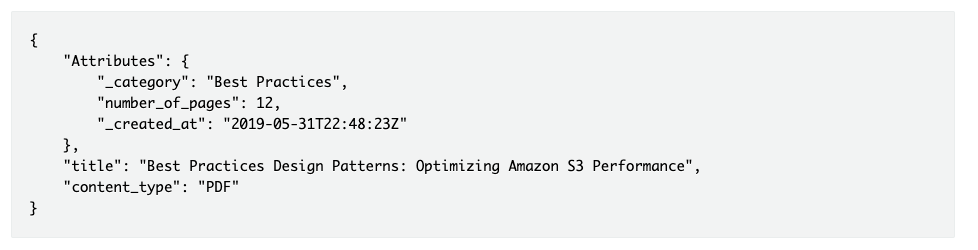

Now, let's copy the dataset with metadata to our S3 bucket.

In [ ]:
!aws s3 cp s3://ml-materials/whitepapers_with_metadata/ s3://{s3Bucket}/whitepapers_with_metadata --recursive 

You should see both PDF as well as JSON files (metadata files) in the bucket.

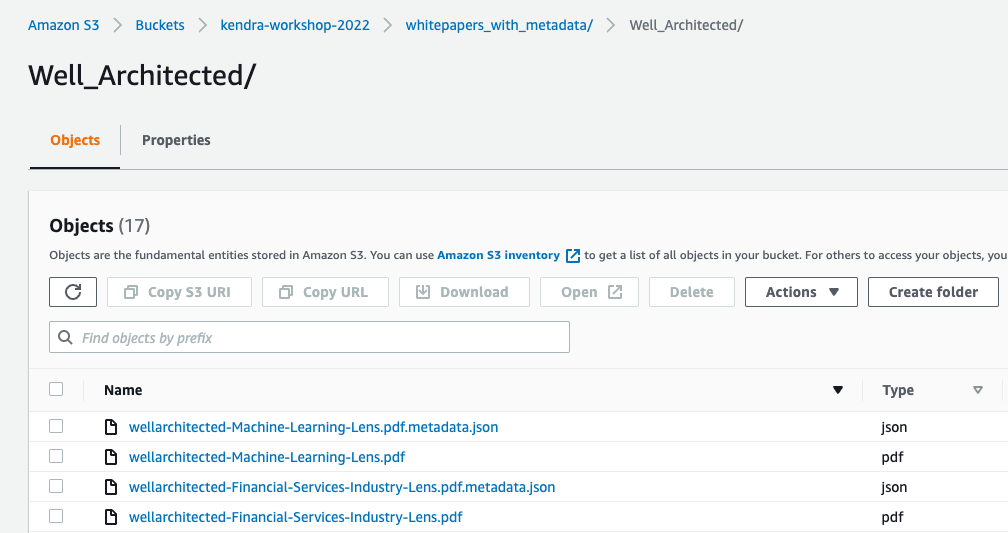

Next, we will be creating some **FACET**s so that we can filter our search by the metadata that we just uploaded. 

Navigate back to your Kendra index. You will be introducing a new attribute (field) into your index for number of pages.



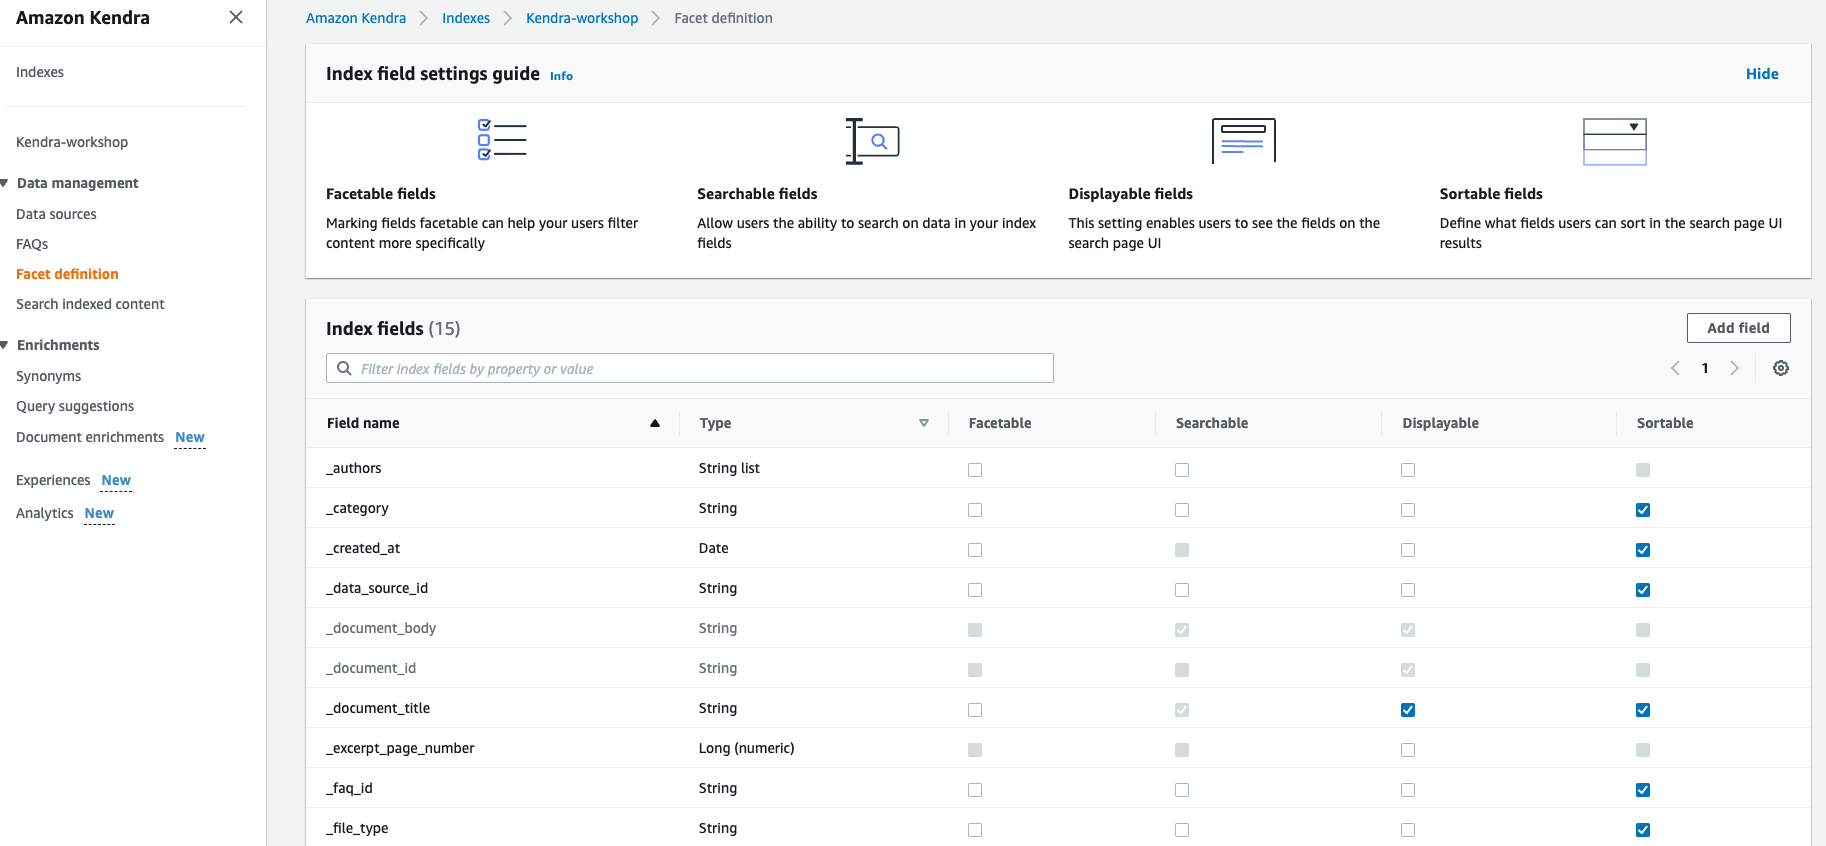


Click on "add field" and **add a custom field for "number_of_pages"**


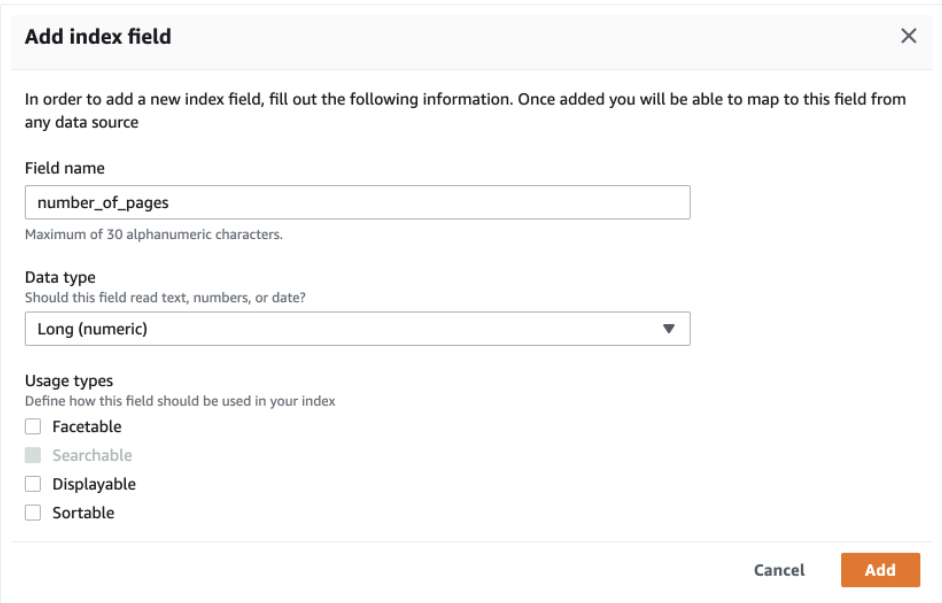

Also, **change the "_category" field to be facetable and displayable**

Next, **edit the data source, remove the previous fix and add the new S3 prefix (whitepapers_with_metadata)**

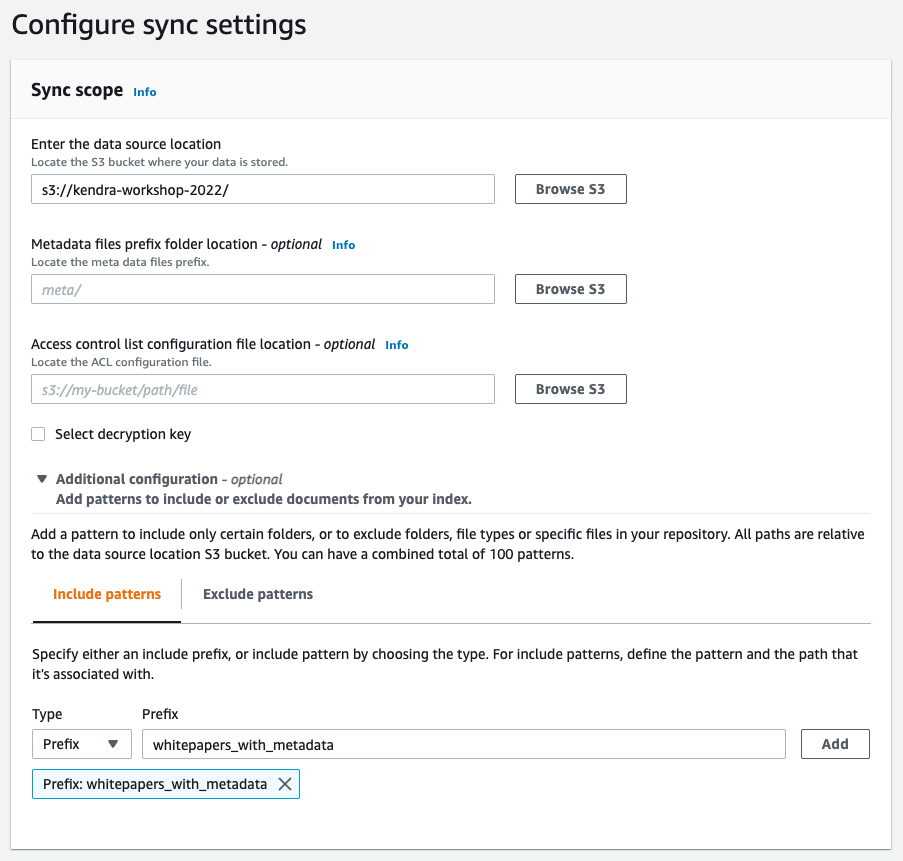

Now, **sync** the data source

Now, let's go to the console and test the search again to see whether we can see the category as filter

## Creating a FAQ document and adding FAQ to index

**First step is to create a FAQ file**. FAQ files need to be in specific formats as mentioned in the below link.
https://docs.aws.amazon.com/kendra/latest/dg/in-creating-faq.html

**A basic CSV file** format: <br>
Use a basic .csv file when you want to use a simple structure for your FAQs. In a basic .csv file, each line has two or three fields: question, answer, and an optional source URI that points to a document with more information.


**A custom CSV file** format: <br>
The .csv file must contain the following two required attributes:<br>

_question: The frequently asked question <br>
_answer: The answer to the frequently asked question <br>
Your file can also contain built-in and custom attributes. <br>

Below is what we will use (a basic CSV file)

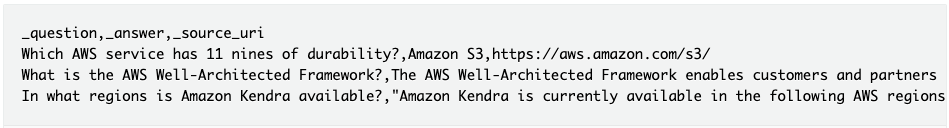

**You can easily add the FAQ file to the index using the console.** 

1) Download the file from your notebook to your local and import the FAQ file to your S3 bucket <br>


2) Use console to add the FAQ file to the index. 

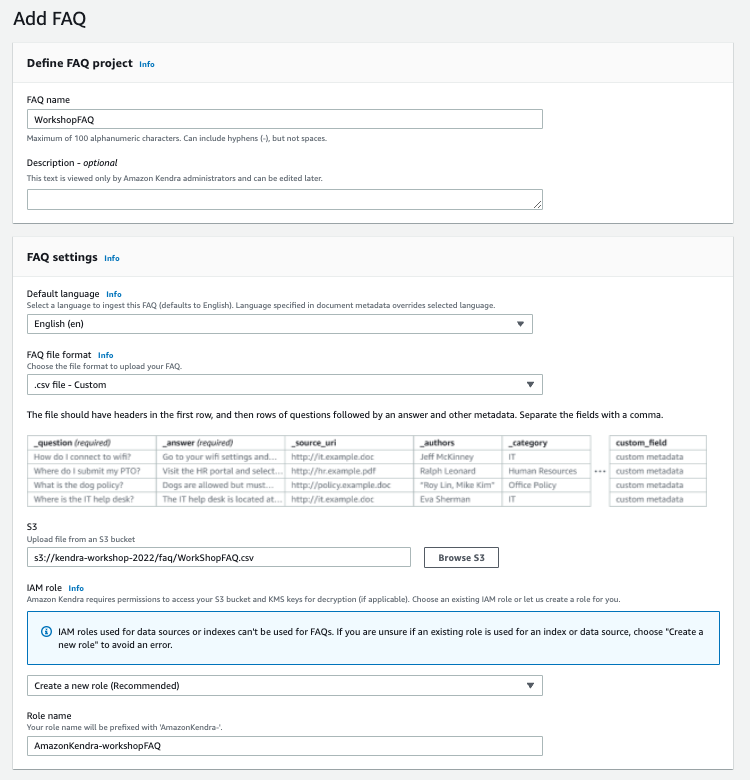

Please note that **if you want to modify the FAQ document after you create the FAQ in Kendra, you will need to delete the existing FAQ and create a new one**

**Maximum size of 1 FAQ file: 1MB and total # of FAQ files: 30. This service quota can be increased upon request**

It might take a min or two to see the FAQ appearing in the search.




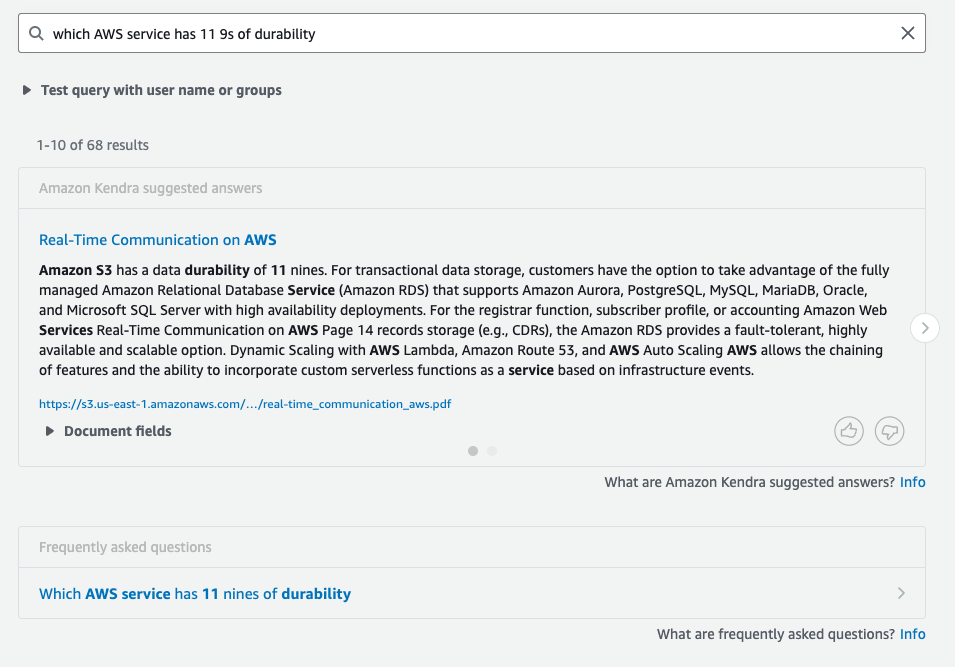

## Adding Synonyms

To add synonyms to an index, you specify them in a thesaurus file. You can include business-specific terms in Amazon Kendra using synonyms. Generic English synonyms, such as leader, head, are built into Amazon Kendra and should not be included in a thesaurus file. 

Although synonyms can improve search accuracy, it is important to understand how synonyms affect latency so you can optimize for this.

There are two ways to specify synonym mappings:

**Bidirectional synonyms** are specified as a comma-separated list of terms. If the token matches any of the terms, then all the terms in the list are substituted, which includes the original token.

*Example:*
HDFS, Hadoop Distributed File System


**Unidirectional synonyms** are specified as two comma-separated lists of terms with the symbol "=>" between them. If the token matches any word on the left, then the list on the right is substituted. Mapping is only from the left to the right.

**You can have up to 10 synonyms per term**

**It can take up to 30 minutes to see the effects of your updated thesaurus file**


## Using Kendra Query

Before you can query using Kendra API, you need to first add Kendra access to your SageMaker role.

Go to SageMaker notebook instances, click on the notebook instance link, and then click on the IAM role ARN link. That should open-up the IAM page for the role. 

Click "Add permission" > "attach policies". Then search for Kendra in the policies and select 'AmazonKendraFullAccess' > Attach it.

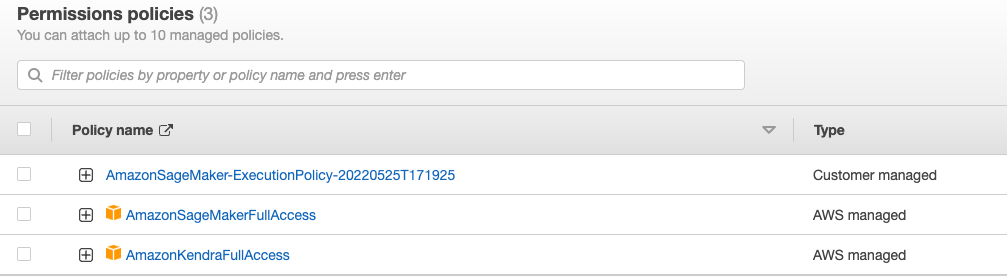

Now, we will do some **Kendra query using API**

In [6]:
# Define Kendra client
kendra = boto3.client('kendra')

In [22]:
#query = 'what is the difference between AI and ML'
query='What is SageMaker'

Now, copy the IndexId from the Kendra console (click on the index that you created and you will see the Index settings).

Paste the Index ID in the "IndexId" field in below cell.

In [23]:
indexId = '884609ed-c06c-452f-9383-b708df745995'   #remember to change to your index ID here

In [24]:
response=kendra.query(
        QueryText = query,
        IndexId = indexId, # paste the Index ID here
        #QueryResultTypeFilter='ANSWER'
)

In [25]:
# Print function to return the most similar answers to the query based on semantic similarity.
def print_results(response, result_number):
    print ('\nSearch results for query: ' + query + '\n') 
    print('-----------------------------------')
    count = 0
    for query_result in response['ResultItems']:
        
        if query_result['Type']=='QUESTION_ANSWER':
            document_text = query_result['AdditionalAttributes'][1]['Value']['TextWithHighlightsValue']['Text']
            print('Type: ' + str(query_result['Type']))
            for item in query_result['DocumentAttributes']:
                if item['Key']=='_category':
                    print('Document Category: ' + item['Value']['StringValue']+'\n')
            print(document_text)
            print('-----------------------------------')
            count += 1

        if query_result['Type']=='ANSWER':
            answer_text = query_result['AdditionalAttributes'][0]['Value']['TextWithHighlightsValue']['Text']
            print('Type: ' + str(query_result['Type']))
            for item in query_result['DocumentAttributes']:
                if item['Key']=='_category':
                    print('Document Category: ' + item['Value']['StringValue']+'\n')
            print(answer_text)                        
            print('-----------------------------------')
            count += 1
            
        if query_result['Type']=='DOCUMENT':
            document_text = query_result['DocumentExcerpt']['Text']
            print('Type: ' + str(query_result['Type']))
            for item in query_result['DocumentAttributes']:
                if item['Key']=='_category':
                    print('Document Category: ' + item['Value']['StringValue']+'\n')
            print(document_text)
            print('-----------------------------------')
            count += 1
            
        if count >= result_number:
            break

In [26]:
print_results(response, 3) 


Search results for query: What is SageMaker

-----------------------------------
Type: ANSWER
Document Category: Machine Learning

In order to achieve this automation, historical data 


may need to be used to build and train machine learning models. Amazon 


SageMaker is a fully managed service that provides developers and data scientists 


with the ability to build, train, and deploy machine learning (ML) models quickly. 


SageMaker removes the heavy lifting from each step of the machine learning 


process to make it easier to develop high quality models. SageMaker makes it easy 


to deploy your trained model into production with a single click so that you can start 


generating predictions on the claims and application data.
-----------------------------------
Type: ANSWER
Document Category: General

All devices listed in the AWS Partner Device Catalog are also available 
for purchase from our partners to get you started quickly. 


Machine Learning 


Amazon SageMaker 
Amazo

## Tuning search relevance at Index level

If you update search relevance at index level, you will not be able to customize at query level.

Now, let's change the the boost value to 10

In [ ]:
response = kendra.update_index(
    Id=indexid,
    DocumentMetadataConfigurationUpdates=[
        {
            "Name": "_category",
            'Type': 'STRING_VALUE',
            "Relevance": {
                    'ValueImportanceMap': {
                        'Databases': 10
            }
        }}])

Now, we can go to the console and check if the boosting is really 10. You will see that boosting for database has been increased to 10

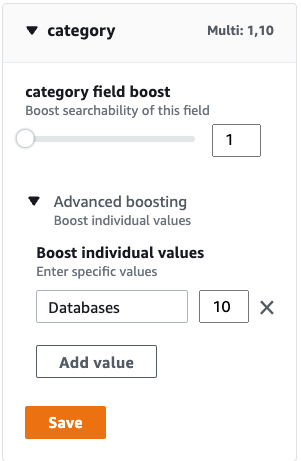

## Submitting feedback for incremental learning


Kendra uses incremental learning to improve search results. Using feedback from queries, incremental learning improves the ranking algorithms and optimizes search results for greater accuracy.

Incremental learning is enabled for all indexes and for all document types.

Kendra starts learning as soon as you provide feedback, though it can take over 24 hours to see the results of the feedback. 

Amazon Kendra provides **3 methods for you to submit feedback**: 

- AWS console, 
- A JavaScript library that you can include on your search results page, 
- An API that you can use.

Amazon Kendra accepts **two types of user feedback**:

- **Clicks**:  Information about which query results the user chose. To submit click feedback, your application must collect click information from the activities of your users, and then submit that information to Amazon Kendra. You can collect click information with the console, the JavaScript library, and the Amazon Kendra API. 

- **Relevance**: Information about the relevance of a search result, which the user typically provides. The feedback contains the result ID and a relevance indicator (RELEVANT or NOT_RELEVANT). You can only collect relevance information with the console and the Amazon Kendra API.

Links to Documentation:

https://docs.aws.amazon.com/kendra/latest/dg/feedback-api.html

https://docs.aws.amazon.com/kendra/latest/dg/feedback-javascript.html



## Querying Kendra metrics

There are 10 metrics for analyzing your search application's performance or what information your users are searching for. To retrieve the metrics data, you specify the string name of the metric data you want to retrieve when you call `GetSnapshots` API.

The metrics supported are as shown below. There are 5 metrics which include trends data for us to visualize and look for patterns over time. The metrics without the trend data does not have date information as these are aggregated data for the specific time interval.

**Metrics with daily trend Data:**

* Click-through rate 
* Zero click rate 
* Zero search results rate
* Instant answer rate
* Total queries
    
**Metrics with Aggregated data:**

* Top queries
* Top queries with zero clicks
* Top queries with zero search results
* Top clicked on documents
* Total documents



You also must provide a time interval or time window to view the metrics data. You can view data in the following time windows:

- THIS_WEEK: The current week, starting on the Sunday and ending on the day before the current date.

- ONE_WEEK_AGO: The previous week, starting on the Sunday and ending on the following Saturday.

- TWO_WEEKS_AGO: The week before the previous week, starting on the Sunday and ending on the following Saturday.

- THIS_MONTH: The current month, starting on the first day of the month and ending on the day before the current date.

- ONE_MONTH_AGO: The previous month, starting on the first day of the month and ending on the last day of the month.

- TWO_MONTHS_AGO: The month before the previous month, starting on the first day of the month and ending on last day of the month.




In [ ]:
import boto3
import pandas as pd
import json
import ast

In [ ]:
# Querying individual metrics

interval = "THIS_MONTH"
metric_type = "QUERIES_BY_COUNT"

snapshots_response = kendra.get_snapshots(
    IndexId = indexId,
    Interval = interval,
    MetricType = metric_type
)
print(snapshots_response["SnapshotsDataHeader"])
for items in snapshots_response["SnapshotsData"]:
    print('\n'+ str(items))

In [ ]:
# Querying metrics trend for a specific time interval

response = kendra.get_snapshots(
    IndexId='884609ed-c06c-452f-9383-b708df745995',
    Interval='THIS_WEEK',
    MetricType='TREND_QUERY_DOC_METRICS',
    MaxResults=10
)

In [ ]:
metrics_data=pd.read_json(json.dumps(response['SnapshotsData']))
metrics_data.columns=['metric', 'Data']
metrics_data['Data'] = metrics_data['Data'].apply(ast.literal_eval)
metrics = metrics_data.explode('Data').reset_index(drop=True)
metrics = metrics.join(pd.DataFrame(metrics.pop('Data').tolist())).groupby('metric').sum()

In [ ]:
# Save to a CSV file
metrics.to_csv('Metrics_data.csv', index=True)

In [ ]:
import pandas as pd
df = pd.read_csv('Metrics_data.csv')
df.head()

## Query Suggestion Config

You can use the below to check default config for query suggestion and also update the default setting

In [ ]:
response = kendra.describe_query_suggestions_config(
    IndexId=indexId
)

In [ ]:
print('QueryLogLookBackWindowInDays: ', response['QueryLogLookBackWindowInDays'])
print('IncludeQueriesWithoutUserInformation: ', response['IncludeQueriesWithoutUserInformation'])
print('MinimumNumberOfQueryingUsers: ', response['MinimumNumberOfQueryingUsers'])
print('MinimumQueryCount: ', response['MinimumQueryCount'])

Now, let's change the "MinimumQueryCount" to 2

In [ ]:
response = kendra.update_query_suggestions_config(
    IndexId=indexId,
    MinimumNumberOfQueryingUsers=1,
    MinimumQueryCount=2
)

In [ ]:
response = kendra.describe_query_suggestions_config(
    IndexId=indexId
)

In [ ]:
print('MinimumQueryCount: ', response['MinimumQueryCount'])

### Access control in Kendra

Here, we will be using the **Principal Store"** feature in Kendra to do access control for some users. 

The Principal Store feature provides an API to store the mapping between a user ID and the groups that it has access to. When a customer application issues a query to the Amazon Kendra index, the application only needs to send the user ID. Amazon Kendra looks up the user ID in the Principal Store and finds the corresponding groups. It then filters the results based on the groups the user has access to.

Let's copy the folders "Best_Practices" and "Well_Architected" to a new folder in your bucket, called "whitepapers_with_metadata_access_control" so that we can implement access control here

In [ ]:
!aws s3 cp s3://ml-materials/whitepapers_with_metadata/Best_Practices s3://{s3Bucket}/whitepapers_with_metadata_access_control/Best_Practices --recursive 

In [ ]:
!aws s3 cp s3://ml-materials/whitepapers_with_metadata/Well_Architected s3://{s3Bucket}/whitepapers_with_metadata_access_control/Well_Architected --recursive 

We will **create a new data source ID** with the dataset "whitepapers_with_metadata_access_control", which only contains two folders - 'Best_Practices" and "Well_Architected". We will limit access to this folder to specific users. 

Once the data source is created, **sync with the index**

In [ ]:
DataSourceId1 = '74895ab5-0830-4763-bb5c-fa40add113d7'   #whitepapers
DataSourceId2 = 'f4388fbf-5dba-4d24-ac13-d26d02da5298'   #whitepapers_with_metadata_access_control
query = 'What are UDP Reflection Attacks'

Now, we will define the users and groups and put in principal store/

In [ ]:
response = kendra.put_principal_mapping(
    IndexId=indexid,
    DataSourceId=DataSourceId1,
    GroupId='superUsers',
    GroupMembers={
        'MemberGroups': [
            {
                'GroupId': 'dev',
                'DataSourceId': DataSourceId1
            },
        ],
        'MemberUsers': [
            {
                'UserId': 'user1',
                'UserId': 'user2'
            },
        ]
    },
    #RoleArn='string'
)

In [ ]:
response = kendra.put_principal_mapping(
    IndexId=indexid,
    DataSourceId=DataSourceId2,
    GroupId='biz_users',
    GroupMembers={
        'MemberGroups': [
            {
                'GroupId': 'product_owners',
                'DataSourceId': DataSourceId2
            },
        ],
        'MemberUsers': [
            {
                'UserId': 'user3',
                'UserId': 'user4'
            },
        ]
    },
    #RoleArn='string'
)

Now, let's create an `AccessControlList` and update this in the document metadata.

We created two different data sources. **DataSourceId1** has Databases, General, Machine Learning and Security Category and **DataSourceId2** has best practices and well architected category documents.

We will use the ACL to allow user1, user2 (group: superUser) access only to DataSourceId1 and allow user3 and user4 access only to DataSourceId2.

We will update the metadata files in S3 accordingly to append the new ACL details in the below format

'{
  "AccessControlList": [
    {
      "Name": "user1",
      "Type": "USER",
      "Access": "ALLOW"
    },
    {
      "Name": "user2",
      "Type": "USER",
      "Access": "ALLOW"
    },
    {
      "Name": "superUsers",
      "Type": "GROUP",
      "Access": "ALLOW"
    }
  ]
}'

In [ ]:
s3_acl_1 = {"AccessControlList": [
         {
            "Name": "user1",
            "Type": "USER",
            "Access": "ALLOW"
         },
         {
            "Name": "user2",
            "Type": "USER",
            "Access": "ALLOW"
         },
         {
            "Name": "user3",
            "Type": "USER",
            "Access": "DENY"
         },
         {
            "Name": "user4",
            "Type": "USER",
            "Access": "DENY"
         },
         {
            "Name": "superUsers",
            "Type": "GROUP",
            "Access": "ALLOW"
         }
    ]}

Next cell will update the metadata for the prefix "whitepapers_with_metadata"

In [ ]:
import json
bucket = s3Bucket
client = boto3.client('s3')
paginator = client.get_paginator('list_objects_v2')
result = paginator.paginate(Bucket=bucket)

for page in result:
    if "Contents" in page:
        for key in page[ "Contents" ]:
            if key["Key"].find(".pdf.metadata.json")!=-1 and key["Key"].find('whitepapers_with_metadata/')!=-1:
                metadataFile = key["Key"]
                obj = client.get_object(Bucket=bucket, Key=key["Key"])
                data = obj['Body'].read().decode('utf-8')
                json_content = json.loads(data)
                json_content.update(s3_acl_1)
                client.put_object(
                     Body=bytes(json.dumps(json_content).encode('UTF-8')),
                     Bucket=bucket,
                     Key=key["Key"]
                )

In [ ]:
s3_acl_2 = {"AccessControlList": [
         {
            "Name": "user3",
            "Type": "USER",
            "Access": "ALLOW"
         },
         {
            "Name": "user4",
            "Type": "USER",
            "Access": "ALLOW"
         },
         {
            "Name": "biz_users",
            "Type": "GROUP",
            "Access": "ALLOW"
         }
    ]}

Next cell will update the metadata for the prefix "whitepapers_with_metadata_access_control"

In [ ]:
import json
bucket = s3Bucket
client = boto3.client('s3')
paginator = client.get_paginator('list_objects_v2')
result = paginator.paginate(Bucket=bucket)

for page in result:
    if "Contents" in page:
        for key in page[ "Contents" ]:
            if key["Key"].find(".pdf.metadata.json")!=-1 and key["Key"].find('whitepapers_with_metadata_access_control/')!=-1:
                metadataFile = key["Key"]
                obj = client.get_object(Bucket=bucket, Key=key["Key"])
                data = obj['Body'].read().decode('utf-8')
                json_content = json.loads(data)
                json_content.update(s3_acl_2)
                client.put_object(
                     Body=bytes(json.dumps(json_content).encode('UTF-8')),
                     Bucket=bucket,
                     Key=key["Key"]
                )

Now, go back to your index and data sourced and `sync for both the data sources`, since we added new metadata for access control

Once sync is complete for both data sources, you can test the query again, specifying which user/group it is

In [ ]:
response = kendra.query(
    QueryText = query,
    IndexId = indexId,
    UserContext = {
        'UserId' : "user1",
        'Groups': [
            'superUsers',
        ]
    })

In [ ]:
print_results(response, 3)

In [ ]:
response3 = kendra.query(
    QueryText = query,
    IndexId = indexId,
    UserContext = {
        'UserId' : "user3",
        'Groups': [
            'Biz_users',
        ]
    })

In [ ]:
print_results(response3, 3)

*You can see that user1 query response comes from different folders since user1 has access to all the folders*

*But user3 query response comes only from Well Architected or Best Practices which user3 has access to.*

### Using Custom Document Enrichment during document ingestion process

Custom Document Enrichment (CDE) enables you to create, modify, or delete document metadata and content when you ingest your documents into Amazon Kendra.

We will automatically `assign category attributes based on the subdirectory of the document being ingested`

We will also `extract text from picture and video using predefined Lambda function.`

Click on the below link to launch the `AWS CloudFormation` to deploy the preExtraction and postExtraction Lambda functions and the required AWS Identity and Access Management (IAM) roles. It will open the AWS CloudFormation Management Console.

- Provide a unique name for your CloudFormation stack and the name of your S3 bucket.
- Choose Next, select the acknowledgement check boxes, and choose Create stack.
- After the stack creation is complete, note the contents of the Outputs. We use these values later.

https://console.aws.amazon.com/cloudformation/home?#/stacks/create/review?templateURL=https://aws-ml-blog.s3.amazonaws.com/artifacts/enrich-your-content-and-metadata-custom-document-enrichment-kendra/cde-blog-template.yaml
    

We will use dataset "Media" here to create the metadata during ingestion. Copy the data to your s3 bucket.
The Media folder contains two image files: Yosemite.png and Yellowstone.png. These are scanned pictures of the Wikipedia pages of Yosemite National Park and Yellowstone National Park. It also contains a video file "How_do_I_configure_a_VPN_over_AWS_Direct_Connect_.mp4".

In [ ]:
! aws s3 cp s3://ml-materials/Media/ s3://{s3Bucket}/Media/ --recursive

We will now configure CDE basic and advanced operations.

- Choose Document enrichment in the navigation pane.
- Choose Add document enrichment.
- For Data Source ID, select the ID from the drop-down.
- Enter a basic operations as shown below. The basic operations look for the sub-strings 'Media' in the attribute _source_uri, that contains the full path to the documents getting ingested and automatically set the _category attribute to Media, and they become available as facets

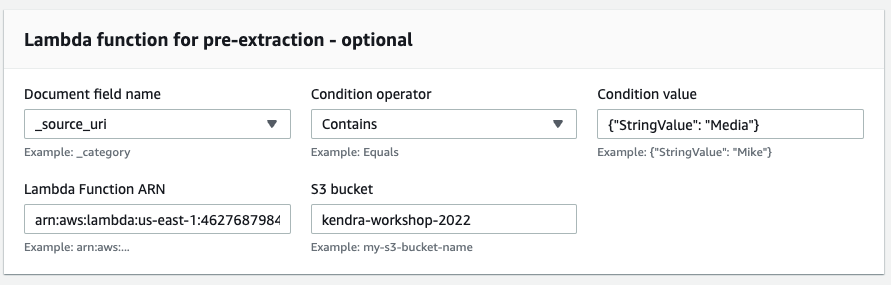

In the next step, you need the ARNs of the preExtraction and postExtraction functions (available on the Outputs tab of the CloudFormation stack that you created). We use the same bucket that you’re using as the data source bucket.

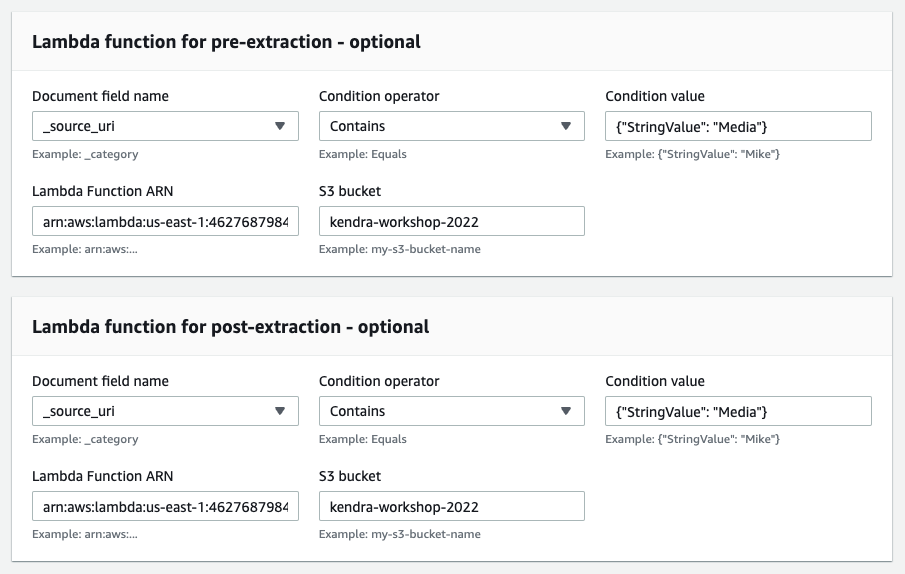

For Service permissions, choose Enter custom role ARN and enter the CDERoleARN value (available on the Outputs tab of cloud formation stack).

Choose `Next` and Choose `Add document enrichment`. It might take a min to add this CDE.

Browse back to the data source we’re using by choosing Data sources in the navigation pane and choose the data source.

Edit the data source and add additional prefix "Media" under "include patterns"

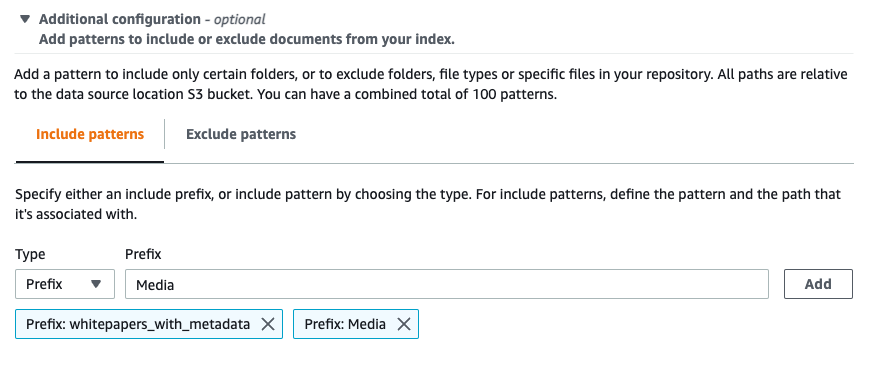

Confirm the changes for the data source editing and then start sync.

While syncing is ongoing, please make sure that the "_category" facet is facetable, searchable

Once syncing/indexing is done, you can go back to the "search indexed content" in console and enter the query "Where is Yosemite national park?" and then click on "Filter search results" on the left. You will see a screen as below:

You can see that now there is a new category called "Media" in the filter for search. This was added using the CDE that we had set-up



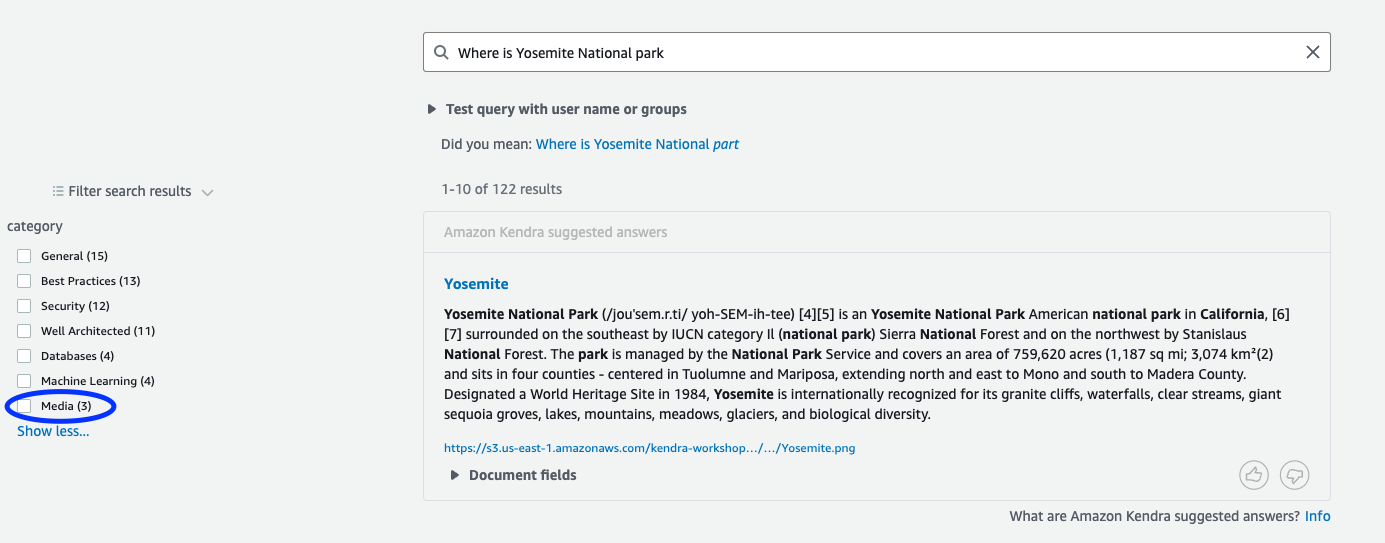

If you click on the "Yosemite" link, the original image will be shown as below.

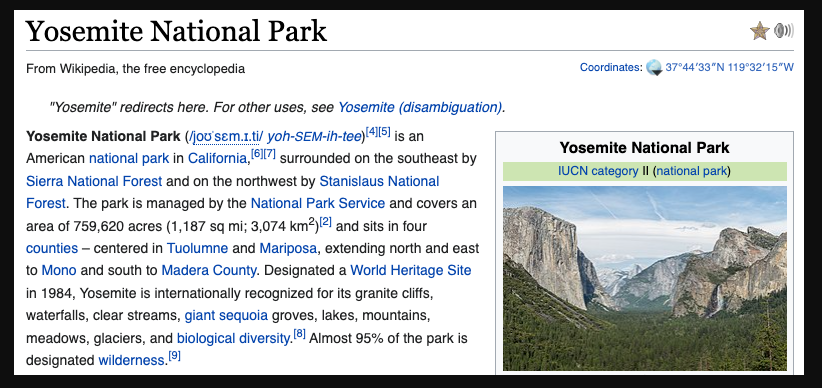

Enter a new query in search window - "What is the process to configure VPN over AWS Direct Connect?". The result would look as below:

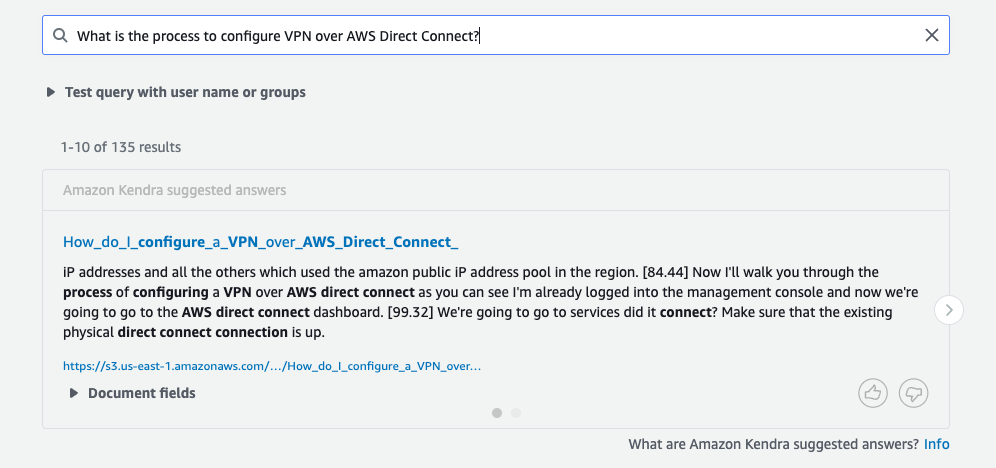

If you click on the link "How do I configure...", the video will open-up.

## Reference Materials


**1. Kendra Deployment**

Documentation Link: https://docs.aws.amazon.com/kendra/latest/dg/deploying.html

Below are links to code samples providen by Amazon Kendra team to build your own search application.

There are two examples you can use with React:

https://kendrasamples.s3.amazonaws.com/kendrasamples-react-app.zip – An example React application that provides sample data and a search page.

https://kendrasamples.s3.amazonaws.com/kendrasamples.zip – A library that you can add to an existing React application.

To deploy a search application with no code and generate an endpoint URL to your search page with access control, you can use **Amazon Kendra Experience Builder**, but it needs AWS SSO login

**2. Useful Blogs**

Building a secure search application with access controls using Amazon Kendra
https://aws.amazon.com/blogs/machine-learning/building-a-secure-search-application-with-access-controls-using-amazon-kendra/

Simplify secure search solutions with Amazon Kendra’s Principal Store
https://aws.amazon.com/blogs/machine-learning/simplify-secure-search-solutions-with-the-new-principal-store-for-secure-search-in-amazon-kendra/

Custom Document Enrichment
https://aws.amazon.com/blogs/machine-learning/enrich-your-content-and-metadata-to-enhance-your-search-experience-with-custom-document-enrichment-in-amazon-kendra/

Automatically scale Amazon Kendra query capacity units with Amazon EventBridge and AWS Lambda
https://aws.amazon.com/blogs/machine-learning/automatically-scale-amazon-kendra-query-capacity-units-with-amazon-eventbridge-and-aws-lambda/